In [1]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.integrate import odeint
ball_blue=(0.13, 0.67, 0.8)

In [2]:
#Define the model here
def iffl(x, t, *pars):
    #parameters   
    rX, rY, ts, K_t, n, t_induc, lam_s, C_t, alpha_t1_s, alpha_t2_s, alpha_t3_s, \
    D_t1_s, D_t2_s, D_t3_s, alpha_s1_tt, alpha_s2_tt = pars
    
    rZ=1-rX-rY
    
    dx = np.zeros(6)
    # total cell population
    dx[0]    = 0.01*lam_s*x[0]*(1-x[0]/C_t) 
    
    #regulation terms
    Hill_XtoY = x[4]**n/(1+x[4]**n)
    Hill_XtoZ = Hill_XtoY
    Hill_YtoZ = 1.0/(1+x[5]**n)
    
    # protein concentrations
    I = t>t_induc and t<ts
    dx[1]    = 100*alpha_t1_s*rX*x[0]*I - 100*D_t1_s*rX*x[0]*x[1]/(K_t*rX*x[0]+x[1])
    dx[2]    = 100*alpha_t2_s*rY*x[0]*Hill_XtoY*I - 100*D_t2_s*rY*x[0]*x[2]/(K_t*rY*x[0]+x[2])
    dx[3]    = 100*alpha_t3_s*rZ*x[0]*Hill_XtoZ*Hill_YtoZ*I - 100*D_t3_s*rZ*x[0]*x[3]/(K_t*rZ*x[0]+x[3])
    # signal concentrations
    dx[4]    = 10**(-alpha_s1_tt)*x[1]
    dx[5]    = 10**(-alpha_s2_tt)*x[2]
    return dx

#Define a function to find the peak of the pulse in strain Z by solving the model
def findPeak(rX, rY, *pars):
    ts, K_t, n, t_induc, lam_s, C_t, alpha_t1_s, alpha_t2_s, alpha_t3_s, D_t1_s, D_t2_s, D_t3_s, \
    alpha_s1_tt, alpha_s2_tt, N0 = pars
    #### Integrate the ODE of the model
    p_vec1 = (rX, rY, *pars) 
    p_vec = p_vec1[0:-1]
    y_init = np.append(N0,np.zeros(5)) 
    time_vec = np.linspace(0, ts, 541)
    sol = odeint(iffl, y_init, time_vec, args=p_vec)
    p = max(sol[:,3]) #Finds the maximum fluorescence of the signal in strain Z
    return p

C:\Users\Mehdi\anaconda3\lib\site-packages\ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Mehdi\anaconda3\lib\site-packages\ipykernel_launcher.py:80: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Mehdi\anaconda3\lib\site-packages\ipykernel_launcher.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

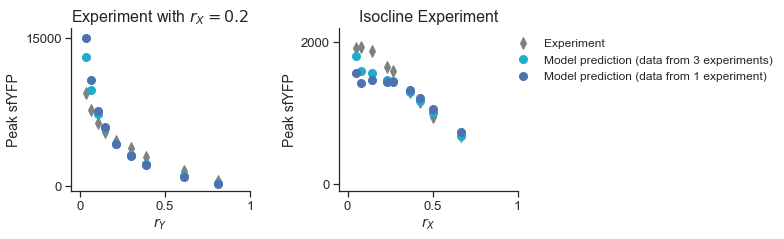

In [3]:
# Load the data from matlab .mat files to get the experimental peaks
fixXData = sio.loadmat('fixX.mat')
day=0 #day 1 of the fix X experiment
peaks_fixX = fixXData['fixX_peaks'][:,day] #gets the peaks of day 1 of this experiment

isocData = sio.loadmat('isocline.mat')
day=1 #day 2 of the isocline experiment
peaks_isoc = isocData['isoc_peaks'][:,day] #gets the peaks of day 2 of this experiment

#Load the measured fractions (NGS results)
measured_fracs = sio.loadmat('measured_fracs_time0.mat')
strainX = 0 #X strain
strainY = 1 #Y strain
exper = 1 #fixX
day=0 #day 1 of the fixX experiment
rX_fixX = measured_fracs['measured_fracs_time0'][strainX,:,day, exper]   
rY_fixX = measured_fracs['measured_fracs_time0'][strainY,:,day, exper]   
exper = 2 #isocline
day=1 #day 2 of the isocline experiment
rX_isoc = measured_fracs['measured_fracs_time0'][strainX,:,day, exper] 
rY_isoc = measured_fracs['measured_fracs_time0'][strainY,:,day, exper] 


 
sns.set()
sns.set(font_scale=1.2)
sns.set_style('ticks')
red_colors = sns.color_palette("Reds_d",9)
blue_colors = sns.color_palette("Blues_d",9)
orange_colors = sns.color_palette("YlOrBr_d",9)
Fig3 = plt.figure(figsize=(8,3))




#Plot the experimental data for the peaks of the pulse in strain Z for the two experiments (fixX and isocline)
plt.subplot(1,2,1) 
plt.plot(rY_fixX, peaks_fixX, marker = 'd', markersize=8, linestyle='none', color='gray', label='Experiment')
plt.subplot(1,2,2)
plt.plot(rX_isoc, peaks_isoc, marker = 'd', markersize=8, linestyle='none', color='gray', label='Experiment')



#Plot model prediction for the peaks based on a fit using 3 experiments
#set parameters of the model
ts = 270.0
K_t = 3.6e4 
n = 2
t_induc = 120.0
N0 = 0.008577 #initial OD

#Load the fitting (inference) results
with open("fitResults1.pkl", "rb") as f:
    data_dict = pickle.load(f)  
stanModel  = data_dict['model']
fitData = data_dict['fit']
trace = fitData.extract() #trace is a dictionary that contains samples and log of the posterior distribution
index_MAP = np.argmax(trace['lp__']) #Finds the index of the parameters with maximum log posterior
MAP_pars_s_3 = trace['theta'][index_MAP,:]
#MAP_pars_s_3=(2.05148731, 0.73775627, 1.85218336, 13.27094864, 14.0472118, \
#                         1.52326606, 3.26004401, 13.93860552, 3.5934674, 4.64180206)

params = (ts, K_t, n, t_induc, *MAP_pars_s_3, N0) 

plt.subplot(1,2,1) 
model_p = np.zeros(9)
for i in range(9):
    model_p[i] = findPeak(rX_fixX[i], rY_fixX[i], *params)    
plt.plot(rY_fixX, model_p, marker = 'o', markersize=8, linestyle='none', color=ball_blue, label='Model prediction (data from 3 experiments)')
plt.xlim([-.05, 1])
plt.xticks((0,0.5,1),(0,0.5,1))
plt.xlabel('$r_Y$', fontsize=14)
plt.ylim([-500, 16000])
plt.yticks([0, 15000])
plt.ylabel('Peak sfYFP', fontsize=14)
#plt.legend(fontsize=12, frameon=False, bbox_to_anchor=(1.2, 1))
plt.title('Experiment with $r_X=0.2$', fontsize=16)


plt.subplot(1,2,2) 
model_p = np.zeros(9)
for i in range(9):
    model_p[i] = findPeak(rX_isoc[i], rY_isoc[i], *params)    
plt.plot(rX_isoc, model_p, marker = 'o', markersize=8, linestyle='none', color=ball_blue, label='Model prediction (data from 3 experiments)')
plt.xlim([-.05, 1])
plt.xticks((0,0.5,1),(0,0.5,1))
plt.xlabel('$r_X$', fontsize=14)
plt.ylabel('Peak sfYFP', fontsize=14)
plt.ylim([-100, 2200])
plt.yticks((0,2000),(0,2000))
plt.title('Isocline Experiment', fontsize=16)


#Plot model prediction for the peaks based on a fit using 1 experiment
#Load the fitting (inference) results for the case where only 1 experiment was used for data
with open("fitResults_based_on_cond5_d2_fixX.pkl", "rb") as f:
    data_dict = pickle.load(f)  
stanModel2  = data_dict['model']
fitData2 = data_dict['fit']
trace = fitData2.extract() #trace is a dictionary that contains samples and log of the posterior distribution
index_MAP = np.argmax(trace['lp__']) #Finds the index of the parameters with maximum log posterior
MAP_pars_s_1 = trace['theta'][index_MAP,:]
#MAP_pars_s_1=(2.0905342   0.72618024  1.50352418 13.73288261 19.98371487  1.4144947
#  4.424951   12.61266671  3.67637882  4.31076136)

params = (ts, K_t, n, t_induc, *MAP_pars_s_1, N0) 
plt.subplot(1,2,1) 
model_p = np.zeros(9)
for i in range(9):
    model_p[i] = findPeak(rX_fixX[i], rY_fixX[i], *params)    
plt.plot(rY_fixX, model_p, marker = 'o', markersize=8, linestyle='none', color='b', label='Model prediction (data from 1 experiment)')
sns.despine()

plt.subplot(1,2,2) 
model_p = np.zeros(9)
for i in range(9):
    model_p[i] = findPeak(rX_isoc[i], rY_isoc[i], *params)    
plt.plot(rX_isoc, model_p, marker = 'o', markersize=8, linestyle='none', color='b', label='Model prediction (data from 1 experiment)')
plt.legend(fontsize=12, frameon=False, bbox_to_anchor=(0.9, 1))
sns.despine()





#export figure
Fig3.subplots_adjust(wspace=0.5)
Fig3.savefig("FigS8_model_pred_1and3expers.pdf", bbox_inches='tight', transparent=True)